In [24]:
import pandas as pd
import numpy as np
import datetime
from sklearn.cross_validation import LeaveOneOut
from sklearn.grid_search import (GridSearchCV, RandomizedSearchCV)
from sklearn.metrics import (mean_squared_error, mean_absolute_error)
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier # Used for imputing rare / missing values
# Regressors considered:
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from matplotlib.pyplot import *
from matplotlib import pylab
from pylab import *
%matplotlib inline

In [25]:
FAKE_DATA_RATIO = 311.5
# Set a Random Seed
SEED = 0

In [26]:
# Read Datasets
train = pd.read_csv('train.csv', index_col = 0, parse_dates=[1])
test = pd.read_csv('test.csv', index_col = 0, parse_dates=[1])


In [27]:
print "Train Dimensions:"
print train.shape
print "Test Dimensions:"
print test.shape

Train Dimensions:
(137, 42)
Test Dimensions:
(100000, 41)


In [28]:
# Concatenate train and test together to pre-process and featurize both consistently.
df = pd.concat((test, train), ignore_index=True)
df.describe()

,P1,P10,P11,P12,P13,P14,P15,P16,P17,P18,...,P35,P36,P37,P4,P5,P6,P7,P8,P9,revenue
count,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,...,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,1.370000e+02
mean,4.087930,5.459011,3.311653,5.061765,5.086621,1.280276,1.305641,1.747336,1.156715,1.708789,...,1.833099,1.969222,0.973696,4.395992,1.989614,2.882551,5.300678,4.931304,5.251645,4.453533e+06
std,2.813085,1.763709,2.067903,1.765647,0.979414,2.497106,2.167272,3.172481,2.432137,3.030907,...,3.229052,3.806280,1.677427,1.035796,1.065518,1.532502,2.178739,1.718699,1.702825,2.576072e+06
min,1.000000,4.000000,1.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.149870e+06
25%,2.000000,5.000000,2.000000,4.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,4.000000,1.000000,2.000000,5.000000,4.000000,4.000000,NaN
50%,3.000000,5.000000,3.000000,5.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,4.000000,2.000000,2.000000,5.000000,5.000000,5.000000,NaN
75%,4.000000,5.000000,4.000000,5.000000,5.000000,2.000000,2.000000,3.000000,2.000000,4.000000,...,4.000000,3.000000,2.000000,5.000000,2.000000,4.000000,5.000000,5.000000,5.000000,NaN
max,15.000000,10.000000,10.000000,10.000000,7.500000,15.000000,10.000000,15.000000,15.000000,15.000000,...,15.000000,20.000000,8.000000,7.500000,8.000000,10.000000,10.000000,10.000000,10.000000,1.969694e+07


In [29]:
# Convert date strings to "days open" numerical value
df["Open Date"] = df["Open Date"].apply(pd.to_datetime)
last_date = df["Open Date"].max()
df["Open Date"] = last_date - df["Open Date"] # This becomes a datetime delta object
df["Open Date"] = df["Open Date"].dt.days + 1 # converts the delta object to an int

In [30]:
df["Log Days Opened"] = df["Open Date"].apply(np.log)
df = df.drop(["Open Date"], axis=1)

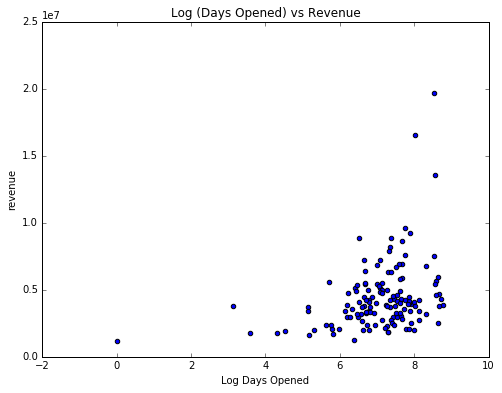

In [31]:
#Graph for log days opened vs revenue
pylab.rcParams['figure.figsize'] = (8, 6) # Resizes plots
df[["Log Days Opened", "revenue"]].plot(x="Log Days Opened", y="revenue", kind='scatter', title="Log (Days Opened) vs Revenue")

In [32]:
# The features with the notable zero behavior:
zero_cols = ['P14', 'P15', 'P16', 'P17', 'P18', 'P24', 'P25', 'P26', 'P27', 'P30', 'P31', 'P32', 'P33', 'P34', 'P35', 'P36', 'P37']

In [33]:
# We make a feature that holds this count of zero columns in the above list
df['zeros'] = (df[zero_cols] == 0).sum(1)

Distribution of new Zeros features:


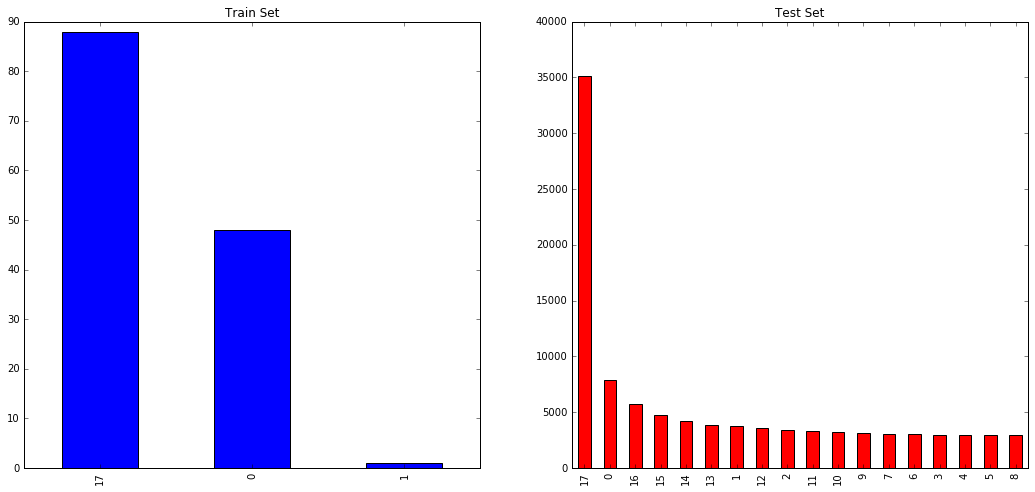

In [34]:
pylab.rcParams['figure.figsize'] = (18, 8)
fig, axs = plt.subplots(1,2)
print "Distribution of new Zeros features:"
# We find there is only 1 row with a zero count between 0 and 17 in the train set, 
df['zeros'].ix[pd.notnull(df.revenue)].value_counts().plot(title="Train Set", kind='bar', ax=axs[0])

# dependence between columns was not preserved).
df['zeros'].ix[pd.isnull(df.revenue)].value_counts().plot(title="Test Set", kind='bar', ax=axs[1], color='red')
plt.show()



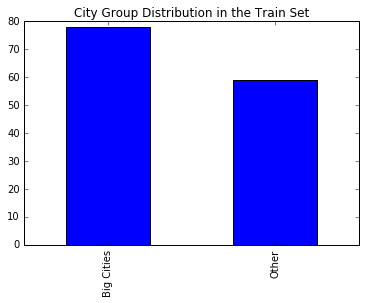

In [35]:
pylab.rcParams['figure.figsize'] = (6, 4) # Resizes plots
# The two categories of City Group both appear very frequently
train["City Group"].value_counts().plot(title="City Group Distribution in the Train Set", kind='bar')
plt.show()


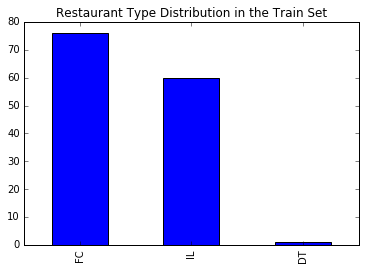

In [36]:
# But two of the four Restaurant Types (DT and FC), are extremely rare
train["Type"].value_counts().plot(title="Restaurant Type Distribution in the Train Set", kind='bar')
plt.show()


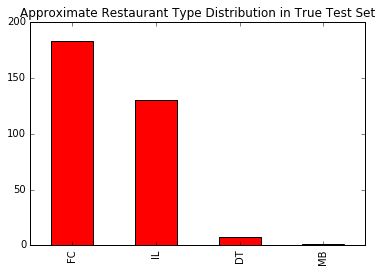

In [37]:
(test["Type"].value_counts() / FAKE_DATA_RATIO).plot(title="Approximate Restaurant Type Distribution in True Test Set", kind='bar', color='Red')
plt.show()

In [38]:
df = df.join(pd.get_dummies(df['City Group'], prefix="CG"))
df = df.join(pd.get_dummies(df['Type'], prefix="T"))


<b>Cleaning the Unwanted Columns

In [39]:

# Since only n-1 columns are needed to binarize n categories, drop one of the new columns.  
# And drop the original columns.
# And also drop the extremely rare restaurant types (which we handleed especially below)
df = df.drop(["City Group", "Type", "CG_Other", "T_MB", "T_DT"], axis=1)
print df.shape

(100137, 44)


In [40]:
# Replace city names with
# count of their frequency in the train + estimated frequency in the test set.
city_counts = (test["City"].value_counts() / FAKE_DATA_RATIO).add(train["City"].value_counts(), fill_value=0)
df["City"] = df["City"].replace(city_counts)
print "Some example estimated counts of restaurants per city:"
print city_counts.head()


Some example estimated counts of restaurants per city:
Adana             11.070626
Afyonkarahisar     2.062600
Aksaray            2.086677
Amasya             1.000000
Ankara            46.993579
Name: City, dtype: float64


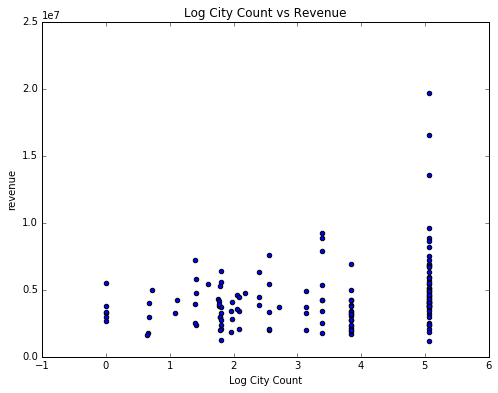

In [41]:
# Take log of city count so that the marginal effect decreases
df["Log City Count"] = df["City"].apply(np.log) 
df = df.drop(["City"], axis=1)
# That last vertical spread of points are restaurants from Istanbul.
pylab.rcParams['figure.figsize'] = (8, 6) 
df[["Log City Count", "revenue"]].plot(x="Log City Count", y="revenue", kind='scatter', title="Log City Count vs Revenue")

In [28]:
# Impute values for the very rare restaurant types. 
# Instead of trying to predict with values that appear only 1 or 0 times in the train set, 
# we will replace them with one of the other commonly appearing categories by fitting a 
# model that predicts which common category they "should" be.
# tofit are the rows in the train set that belong to one of the common restaurnat types
tofit = df.ix[((df.T_FC==1) | (df.T_IL==1)) & (pd.notnull(df.revenue))]
# tofill are rows in either train or test that belong to one of the rare types
tofill = df.ix[((df.T_FC==0) & (df.T_IL==0))]
print "type training set shape:", tofit.shape
print "data to impute:", tofill.shape
# Resaruants with type FC are labeled 1, those with type IL are labeled 0.
y = tofit.T_FC
# Drop the label columns and revenue (which is not in the test set, so can't be used here)
X = tofit.drop(["T_FC", "T_IL", "revenue"], axis=1)
# Define and train a model to impute restaurant type
# The grid below just has a range of values that I've found commonly
# work well with random forest type models (of which ExtraTrees is one).
model_grid = {'max_depth': [None, 8], 'min_samples_split': [4,9,16], 'min_samples_leaf':[1,4], 'max_features':['sqrt', 0.5, None]}
type_model = ExtraTreesClassifier(n_estimators=25, random_state=SEED)
grid = RandomizedSearchCV(type_model, model_grid, n_iter=10, cv=5, scoring="roc_auc")
grid.fit(X, y)
print("Best parameters for Type Model:")
print(grid.best_params_)
type_model.set_params(**grid.best_params_)
type_model.fit(X, y)
imputations = type_model.predict(tofill.drop(["T_FC", "T_IL", "revenue"], axis=1))
df.loc[(df.T_FC==0) & (df.T_IL==0), "T_FC"] = imputations
df = df.drop(["T_IL"], axis=1)
print "% labeled FC in the training set:", df.T_FC.mean()
print "% of imputed values labeled FC:", np.mean(imputations)
# Now binarize the "P" columns with dummy variables
print "Pre-binarizing columns:", len(df.columns)
for col in df.columns:
    if col[0] == 'P':
        print col, len(df[col].unique()), "unique values"
        df = df.join(pd.get_dummies(df[col], prefix=col))
        df = df.drop([col, df.columns[-1]], axis=1)
print "Post-binarizing columns:", len(df.columns)

type training set shape: (136, 44)
data to impute: (2535, 44)
Best parameters for Type Model:
{'min_samples_split': 16, 'max_features': 0.5, 'max_depth': 8, 'min_samples_leaf': 1}
% labeled FC in the training set: 0.587135624195
% of imputed values labeled FC: 0.670216962525
Pre-binarizing columns: 43
P1 9 unique values
P10 4 unique values
P11 8 unique values
P12 7 unique values
P13 5 unique values
P14 10 unique values
P15 9 unique values
P16 10 unique values
P17 10 unique values
P18 9 unique values
P19 9 unique values
P2 9 unique values
P20 9 unique values
P21 9 unique values
P22 5 unique values
P23 9 unique values
P24 9 unique values
P25 9 unique values
P26 10 unique values
P27 10 unique values
P28 9 unique values
P29 8 unique values
P3 8 unique values
P30 10 unique values
P31 10 unique values
P32 10 unique values
P33 7 unique values
P34 11 unique values
P35 8 unique values
P36 10 unique values
P37 8 unique values
P4 7 unique values
P5 7 unique values
P6 8 unique values
P7 7 unique v